<a href="https://colab.research.google.com/github/dfridland/NLP/blob/HW11/NLP_DF_HW11_transformer_actual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer model for language understanding

Основная идея, лежащая в основе модели Transformer, - это самовнимание - способность отслеживать различные позиции входной последовательности для вычисления представления этой последовательности. Transformer создает стопки слоев самовнимания, что объясняется ниже в разделах « Масштабируемое скалярное произведение» и « Многоголовое внимание» .

Модель преобразователя обрабатывает входные данные переменного размера, используя стопки слоев самовнимания вместо RNN или CNN . Эта общая архитектура имеет ряд преимуществ:

* Он не делает никаких предположений о временных / пространственных отношениях между данными. Это идеально подходит для обработки набора объектов.
* Выходы уровня можно вычислять параллельно, а не последовательно, как RNN.
* Отдаленные элементы могут влиять на вывод друг друга, не проходя через множество RNN-шагов или слоев свертки (например, см. Преобразователь памяти сцены ).
* Он может изучать дальнодействующие зависимости. Это проблема для многих задач последовательности.

Минусы этой архитектуры:

* Для временного ряда выход для временного шага рассчитывается из всей истории, а не только из входных данных и текущего скрытого состояния. Это может быть менее эффективно.
* Если вход действительно имеет временное / пространственное соотношение, как текст, должно быть добавлено некоторое позиционное кодирование или модель будет эффективно увидеть мешок слов.

После обучения модели вы сможете ввести предложение на русском и вернуть перевод на английском.


<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

In [1]:
#!pip install -q tfds-nightly
#
# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install matplotlib==3.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 72.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.2.2-cp310-cp310-linux_x86_64.whl size=12292142 sha256=41747323935b3a272284e4e9ce8ba84cf9ff3542e61ce1a4a112cc341163444f
  Stored in directory: /root/.cache/pip/wheels/bb/81/f3/48b8bd245846ae69fcb2281c84e848bfea1f5260a870c148ae
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but yo

In [2]:
#!pip install notebook

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

In [2]:
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Setup input pipeline

Use [TFDS](https://www.tensorflow.org/datasets) to load the Ru-English translation dataset from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [8073, 1034, 8104, 5774, 13, 3531, 8035]
The original string: Transformer is awesome.


Токенизатор кодирует строку, разбивая ее на подслова, если слово отсутствует в его словаре.



In [6]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

8073 ----> T
1034 ----> ran
8104 ----> s
5774 ----> former 
13 ----> is 
3531 ----> awesome
8035 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Добавьте начальный и конечный токены к входу и цели.



The `encode` function takes two language sentences, `lang1` and `lang2`, and encodes them using the respective tokenizers (`tokenizer_pt` for the Portuguese language and `tokenizer_en` for the English language). It performs the following steps:

1. It converts the `lang1` sentence to a numpy array using the `.numpy()` method.
2. It adds the start and end tokens to the `lang1` sentence by appending the vocabulary size and vocabulary size plus one tokens from the Portuguese tokenizer.
3. It performs the same steps for the `lang2` sentence, using the English tokenizer.

Finally, it returns the encoded `lang1` and `lang2` sentences as lists.

Note: The use of `.numpy()` suggests that `lang1` and `lang2` are TensorFlow tensors, and the conversion to numpy arrays is necessary to work with the tokenizers.

In [8]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

Вы хотите использовать Dataset.map чтобы применить эту функцию к каждому элементу набора данных. Dataset.map работает в графическом режиме.

Тензоры графов не имеют значения.
В графическом режиме вы можете использовать только операции и функции TensorFlow.
Таким образом, вы не можете напрямую .map эту функцию: вам нужно обернуть ее в tf.py_function . tf.py_function будет передавать обычные тензоры (со значением и .numpy() для доступа к нему) в .numpy() функцию python.



The tf_encode function is a TensorFlow function that applies the encode function to pairs of sentences in parallel. It takes two arguments, pt and en, which represent batches of sentences in the Portuguese and English languages, respectively. The function performs the following steps:

It uses tf.py_function to wrap the encode function, allowing it to be used within TensorFlow computational graphs.
It passes the pt and en tensors to the encode function as arguments.
It specifies the output types of the resulting tensors as tf.int64 using the result_pt and result_en tensors.
It sets the shapes of the output tensors using set_shape([None]), indicating that the shape of the tensors can vary along the first dimension (batch size).
The function then returns the encoded tensors result_pt and result_en.

This function can be used as a preprocessing step when preparing data for training a sequence-to-sequence model. It allows encoding of batches of sentences in parallel using TensorFlow operations.

In [9]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [10]:
MAX_LENGTH = 40

The `filter_max_length` function is a filtering function that takes in two sequences, `x` and `y`, and a maximum length limit `max_length`. It returns a boolean value indicating whether the lengths of both sequences are less than or equal to the specified maximum length.

The function uses TensorFlow operations to compute the size of the sequences (`tf.size(x)` and `tf.size(y)`) and then applies a logical AND operation (`tf.logical_and`) to check if both sizes are within the maximum length limit.

This function can be used to filter out sequences that exceed a certain length during data preprocessing or when creating a dataset. It ensures that sequences are truncated or omitted if they are too long, which can be useful for managing computational resources or ensuring compatibility with models that have fixed input length requirements.

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

The code snippet provided demonstrates the processing steps for creating the training and validation datasets:

1. `train_examples` and `val_examples` are assumed to be the input examples for the training and validation sets, respectively.
2. The `tf_encode` function is applied to each example in `train_examples` and `val_examples` using the `map` function. This function converts the input sentences from the source language (e.g., Portuguese) and target language (e.g., English) into tokenized sequences represented as integer tensors.
3. The `filter_max_length` function is then applied to both `train_dataset` and `val_dataset` to filter out sequences that exceed the maximum length specified by `MAX_LENGTH`.
4. The `train_dataset` is cached in memory using the `cache` method. Caching the dataset helps to speed up the data reading process.
5. The `train_dataset` is shuffled with a buffer size specified by `BUFFER_SIZE` and then batched into batches of size `BATCH_SIZE` using the `shuffle` and `padded_batch` methods, respectively. Shuffling the dataset ensures randomness during training, and padding the batches ensures that all sequences within a batch have the same length.
6. The `val_dataset` is also processed similarly, but without shuffling. It is only padded into batches using the `padded_batch` method.

Finally, the datasets are ready for training and validation, with the training dataset benefiting from caching, shuffling, and batching operations, and the validation dataset being batched for evaluation.

In [12]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [13]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8179,   57,   86, ...,    0,    0,    0],
        [8179,    3,   38, ...,    0,    0,    0],
        [8179,   57,  135, ...,    0,    0,    0],
        ...,
        [8179,    3,    7, ...,    0,    0,    0],
        [8179,  138,  250, ...,    0,    0,    0],
        [8179,   19,    7, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8245,   90,  101, ...,    0,    0,    0],
        [8245,   70,   25, ...,    0,    0,    0],
        [8245,   90,  153, ...,    0,    0,    0],
        ...,
        [8245,    4,   18, ...,    0,    0,    0],
        [8245,   19,   59, ...,    0,    0,    0],
        [8245,   24,   18, ...,    0,    0,    0]])>)

## Positional encoding

Поскольку эта модель не содержит повторений или сверток, добавляется позиционное кодирование, чтобы дать модели некоторую информацию об относительном положении слов в предложении.

Вектор позиционного кодирования добавляется к вектору внедрения. Вложения представляют собой токен в d-мерном пространстве, где токены с одинаковым значением будут ближе друг к другу. Но вложения не кодируют относительное положение слов в предложении. Таким образом, после добавления позиционной кодировки слова будут ближе друг к другу на основе сходства их значения и их положения в предложении в d-мерном пространстве.

Формула для расчета позиционного кодирования выглядит следующим образом:



$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

The `get_angles` function calculates the angle rates for positional encoding in a Transformer model. It takes three arguments:

1. `pos`: A tensor representing the positions of the elements in a sequence. It has shape `(length,)`, where `length` is the length of the sequence.
2. `i`: An integer representing the dimension index.
3. `d_model`: An integer representing the dimensionality of the model.

The function calculates the angle rates using the formula `1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))`. This formula introduces a scaling factor based on the position and the dimension index to determine the frequency of the sine and cosine functions used for positional encoding.

The `pos` tensor is multiplied element-wise with the angle rates to obtain the final angles. The resulting tensor has the same shape as the `pos` tensor.

The purpose of calculating these angles is to provide a unique positional encoding for each element in the sequence, allowing the Transformer model to capture positional information.

In [14]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

The `positional_encoding` function generates positional encodings for a given sequence length (`position`) and model dimensionality (`d_model`). It uses the `get_angles` function to calculate the angles based on the position and dimension.

Here's how the function works:

1. It first calls `get_angles` with the range of positions (`np.arange(position)[:, np.newaxis]`) and the range of dimensions (`np.arange(d_model)[np.newaxis, :]`), resulting in an `angle_rads` tensor of shape `(position, d_model)`.

2. The `angle_rads` tensor is then modified by applying the `np.sin` function to even indices (`angle_rads[:, 0::2]`) and the `np.cos` function to odd indices (`angle_rads[:, 1::2]`). This ensures that even dimensions capture sine-based positional information, while odd dimensions capture cosine-based positional information.

3. Finally, the `pos_encoding` tensor is created by adding an extra dimension to the modified `angle_rads` tensor (`angle_rads[np.newaxis, ...]`). This extra dimension represents the batch dimension and allows the positional encoding to be broadcasted across multiple sequences.

4. The resulting `pos_encoding` tensor is cast to `tf.float32` data type and returned.

The purpose of positional encoding is to provide the Transformer model with information about the relative positions of elements in the input sequence. It helps the model differentiate between different positions and encode sequential dependencies.

In [15]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

The code snippet you provided generates a positional encoding matrix (`pos_encoding`) for a sequence length of 50 and a model dimensionality of 512. The `pos_encoding` matrix has a shape of `(1, 50, 512)`.

The code then visualizes the positional encoding matrix using a color mesh plot. The x-axis represents the depth or dimension of the model, ranging from 0 to 512. The y-axis represents the position in the sequence, ranging from 0 to 49 (since Python indexing starts from 0).

Each cell in the plot corresponds to the value of the positional encoding at a specific position and dimension. The color intensity represents the magnitude of the value, with a color map ranging from red to blue.

The resulting plot provides a visual representation of how the positional encoding varies across different positions and dimensions. It shows how the encoding values change sinusoidally, alternating between sine and cosine patterns along the depth dimension.

Here's the updated code with the visualization:

```python
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()
```

(1, 50, 512)


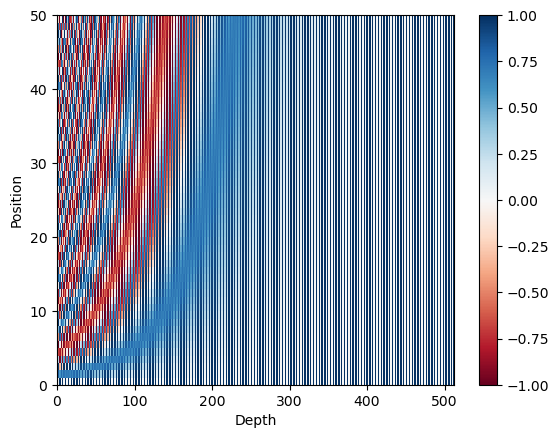

In [16]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Замаскируйте все маркеры площадок в пакете последовательности. Это гарантирует, что модель не обрабатывает отступы как входные данные. Маска указывает, где присутствует значение пэда 0 : она выводит 1 в этих местах и 0 противном случае.

The `create_padding_mask` function you provided creates a padding mask for a given sequence (`seq`). It assumes that the padding token has a value of 0 in the sequence.

Here's how the function works:

1. It uses `tf.math.equal(seq, 0)` to create a tensor of the same shape as `seq`, where each element is `True` if the corresponding element in `seq` is equal to 0, and `False` otherwise.
2. It casts the resulting boolean tensor to `tf.float32` to convert `True` values to 1.0 and `False` values to 0.0.
3. It adds extra dimensions to the tensor to match the expected shape for the attention logits. The resulting tensor has a shape of `(batch_size, 1, 1, seq_len)`, where `batch_size` is the number of sequences in the batch, and `seq_len` is the length of each sequence.

The padding mask is used to mask out the padding tokens during the self-attention computation in the transformer model. By assigning a large negative value (e.g., -1e9) to the padding positions in the attention logits, the softmax operation will effectively assign a probability of 0 to the padding tokens.

Here's an example usage of the `create_padding_mask` function:

```python
seq = tf.constant([3, 0, 7, 0, 0, 2])
padding_mask = create_padding_mask(seq)
print(padding_mask)

Output:
[[[[0. 1. 0. 1. 1. 0.]]]]
```

In this example, the input sequence has a length of 6, and the padding tokens are located at positions 1, 3, 4. The resulting padding mask tensor has a shape of `(1, 1, 1, 6)` and indicates the positions of the padding tokens with a value of 1.0.

In [17]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

Маска упреждающего просмотра используется для маскировки будущих токенов в последовательности. Другими словами, маска указывает, какие записи не следует использовать.

Это означает, что для предсказания третьего слова будут использоваться только первое и второе слово. Аналогично для предсказания четвертого слова будут использоваться только первое, второе и третье слово и так далее.



In [18]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [19]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Функция внимания, используемая преобразователем, принимает три входа: Q (запрос), K (ключ), V (значение). Уравнение, используемое для расчета весов внимания:


$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Внимание скалярного произведения масштабируется с коэффициентом квадратного корня из глубины. Это сделано потому, что для больших значений глубины скалярное произведение увеличивается по величине, подталкивая функцию softmax, где у него есть небольшие градиенты, что приводит к очень жесткому softmax.

Например, предположим, что Q и K имеют среднее значение 0 и дисперсию 1. Их матричное умножение будет иметь среднее значение 0 и дисперсию dk . Следовательно, для масштабирования используется квадратный корень из dk (а не какое-либо другое число), потому что матрица Q и K должна иметь среднее значение 0 и дисперсию 1, и вы получите более мягкий softmax.

Маска умножается на -1e9 (близко к отрицательной бесконечности). Это сделано потому, что маска суммируется с умножением масштабированной матрицы Q и K и применяется непосредственно перед softmax. Цель состоит в том, чтобы обнулить эти ячейки, и большие отрицательные входные данные для softmax близки к нулю на выходе.



In [20]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Поскольку нормализация softmax выполняется для K, его значения определяют степень важности, придаваемой Q.

Выходные данные представляют собой умножение весов внимания и вектора V (значения). Это гарантирует, что слова, на которых вы хотите сосредоточиться, останутся как есть, а нерелевантные слова будут удалены.



In [21]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [22]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [23]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [24]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [25]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Многоголовое внимание состоит из четырех частей:

* Слои линейные и разбиваются на головы.
* Повышенное внимание к скалярному продукту
* Конкатенация голов.
* Финальный линейный слой.

Каждый блок внимания с несколькими головами получает три входа; Q (запрос), K (ключ), V (значение). Они проходят через линейные (плотные) слои и разбиваются на несколько головок.

scaled_dot_product_attention определенный выше, применяется к каждой голове (транслируется для эффективности). На этапе внимания необходимо использовать соответствующую маску. Затем вывод внимания для каждой головы объединяется (с использованием tf.transpose и tf.reshape ) и пропускается через последний слой Dense .

Вместо одной единственной головы внимания Q, K и V разделены на несколько голов, потому что это позволяет модели совместно обращать внимание на информацию в разных положениях из разных пространств представления. После разделения каждая голова имеет уменьшенную размерность, поэтому общая стоимость вычислений такая же, как и внимание одной головы с полной размерностью.



In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Создайте слой MultiHeadAttention чтобы попробовать. В каждом месте в последовательности y MultiHeadAttention запускает все 8 головок внимания по всем другим местам в последовательности, возвращая новый вектор той же длины в каждом месте.



In [27]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Сеть с точечной прямой связью состоит из двух полностью связанных слоев с активацией ReLU между ними.
The code implements a point-wise feed-forward network using the TensorFlow library. Let's break it down:

The point_wise_feed_forward_network function takes two arguments:

d_model: This represents the input and output dimension of the feed-forward network, which is the model's hidden size or embedding dimension.
dff: This specifies the hidden dimension of the feed-forward network, determining the size of the intermediate representation.
The function returns a tf.keras.Sequential model, which is a linear stack of layers.

The point-wise feed-forward network consists of two tf.keras.layers.Dense layers:

The first dense layer has dff units and applies the ReLU activation function. It transforms the input tensor from shape (batch_size, seq_len, d_model) to shape (batch_size, seq_len, dff).
The second dense layer has d_model units and does not have an activation function specified. It transforms the tensor back to the original input dimension, resulting in the output tensor shape (batch_size, seq_len, d_model).
In summary, this code defines a point-wise feed-forward network with two dense layers in a sequential manner. The first dense layer transforms the input tensor to a higher-dimensional representation using ReLU activation, and the second dense layer maps it back to the original dimension without any activation function.


In [28]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [29]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Модель трансформера следует той же общей схеме, что и стандартная последовательность действий с моделью внимания .

Входное предложение проходит через N уровней кодировщика, которые генерируют выходные данные для каждого слова / токена в последовательности.
Декодер отслеживает вывод кодировщика и свой собственный ввод (самовнимание), чтобы предсказать следующее слово.


### Encoder layer

Каждый уровень кодировщика состоит из подслоев:

Многоголовое внимание (с дополнительной маской)
Точечные сети прямого распространения.
Каждый из этих подуровней имеет остаточную связь вокруг себя, за которой следует нормализация уровня. Остаточные соединения помогают избежать проблемы исчезающего градиента в глубоких сетях.

Результатом каждого подслоя является LayerNorm(x + Sublayer(x)) . Нормализация выполняется по d_model (последняя). В трансформаторе N слоев кодировщика.



Sure! The code snippet you provided defines an `EncoderLayer` class in TensorFlow. Let's break it down step by step:

1. The `EncoderLayer` class is derived from `tf.keras.layers.Layer`, indicating that it is a custom layer in TensorFlow.

2. The `__init__` method is the constructor of the class. It takes four arguments:
   - `d_model`: The input and output dimension of the encoder layer, representing the hidden size or embedding dimension.
   - `num_heads`: The number of heads in the multi-head attention mechanism.
   - `dff`: The dimension of the hidden layer in the point-wise feed-forward network.
   - `rate`: The dropout rate, which is set to 0.1 by default.

3. Inside the constructor, the following components are defined:
   - `self.mha`: An instance of the `MultiHeadAttention` class, representing the multi-head attention mechanism. It takes `d_model` and `num_heads` as arguments.
   - `self.ffn`: An instance of the `point_wise_feed_forward_network` function, representing the point-wise feed-forward network. It takes `d_model` and `dff` as arguments.
   - `self.layernorm1` and `self.layernorm2`: Instances of `tf.keras.layers.LayerNormalization`, representing the layer normalization operations applied to the outputs.
   - `self.dropout1` and `self.dropout2`: Instances of `tf.keras.layers.Dropout`, representing dropout layers for regularization.

4. The `call` method defines the forward pass of the `EncoderLayer`:
   - It takes three arguments: `x` (the input tensor), `training` (a boolean flag indicating whether the model is in training or inference mode), and `mask` (an optional mask tensor for masking padded positions).
   - The multi-head attention mechanism (`self.mha`) is applied to the input `x` three times with the same inputs (`x`, `x`, `x`) and the `mask` to obtain `attn_output`, which represents the attention-weighted sum of the input.
   - The `attn_output` is then passed through the first dropout layer (`self.dropout1`) with the specified dropout rate and the `training` flag.
   - The original input `x` is added to the dropout output, and the result is normalized using `self.layernorm1`.
   - The output of the layer normalization (`out1`) is passed through the point-wise feed-forward network (`self.ffn`) to obtain `ffn_output`.
   - The `ffn_output` is then passed through the second dropout layer (`self.dropout2`) with the specified dropout rate and the `training` flag.
   - The original input `x` is again added to the dropout output, and the result is normalized using `self.layernorm2`.
   - The final output of the `EncoderLayer` is returned as `out2`.

In summary, the `EncoderLayer` class represents a single layer in the encoder of a transformer model. It consists of a multi-head attention mechanism, a point-wise feed-forward network, layer normalization operations, and dropout layers for regularization. The `call` method defines the computations performed during the forward pass.

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

The code snippet you provided demonstrates the usage of the `EncoderLayer` class. Let's go through it step by step:

1. `sample_encoder_layer` is an instance of the `EncoderLayer` class created with the following arguments:
   - `d_model = 512`: The input and output dimension of the encoder layer.
   - `num_heads = 8`: The number of heads in the multi-head attention mechanism.
   - `dff = 2048`: The dimension of the hidden layer in the point-wise feed-forward network.
   - The `rate` argument is not provided, so it takes the default value of 0.1.

2. `sample_encoder_layer_output` is obtained by calling `sample_encoder_layer` with the following arguments:
   - `tf.random.uniform((64, 43, 512))`: A random input tensor of shape `(batch_size, input_seq_len, d_model)`. Here, the batch size is 64, the input sequence length is 43, and the hidden size (d_model) is 512.
   - `False`: The `training` flag is set to `False`, indicating that the model is in inference mode.
   - `None`: The `mask` argument is set to `None`, meaning no masking is applied.

3. Finally, `sample_encoder_layer_output.shape` is used to print the shape of the output tensor. The expected shape is `(batch_size, input_seq_len, d_model)`, which represents the batch size, sequence length, and hidden size of the encoder layer output.

By running this code, you will obtain the shape of the output tensor from the sample encoder layer.

In [31]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Каждый слой декодера состоит из подслоев:

Замаскированное внимание с несколькими головами (с опережающей маской и дополнительной маской)
Многоголовое внимание (с дополнительной маской). V (значение) и K (ключ) получают выходной сигнал энкодера в качестве входных данных. Q (запрос) получает выходные данные от подуровня замаскированного многоголового внимания.
Точечные сети прямого распространения
Каждый из этих подуровней имеет остаточную связь вокруг себя, за которой следует нормализация уровня. Результатом каждого подслоя является LayerNorm(x + Sublayer(x)) . Нормализация выполняется по d_model (последняя).

В трансформаторе N слоев декодера.

Поскольку Q принимает выходные данные от первого блока внимания декодера, а K принимает выходные данные кодировщика, веса внимания представляют важность, придаваемую входу декодера на основе выходных данных кодера. Другими словами, декодер предсказывает следующее слово, глядя на выходные данные кодировщика и самостоятельно присматриваясь к своим собственным выходным данным. См. Демонстрацию выше в разделе «Внимание к скалярному произведению».



The code you provided defines a `DecoderLayer` class in TensorFlow. Let's break it down step by step:

1. The `DecoderLayer` class is derived from `tf.keras.layers.Layer`, indicating that it is a custom layer in TensorFlow.

2. The `__init__` method is the constructor of the class. It takes four arguments:
   - `d_model`: The input and output dimension of the decoder layer, representing the hidden size or embedding dimension.
   - `num_heads`: The number of heads in the multi-head attention mechanisms.
   - `dff`: The dimension of the hidden layer in the point-wise feed-forward network.
   - `rate`: The dropout rate, which is set to 0.1 by default.

3. Inside the constructor, the following components are defined:
   - `self.mha1` and `self.mha2`: Instances of the `MultiHeadAttention` class, representing the two multi-head attention mechanisms used in the decoder layer. The first one operates on the target sequence, and the second one attends to the encoder output.
   - `self.ffn`: An instance of the `point_wise_feed_forward_network` function, representing the point-wise feed-forward network in the decoder layer.
   - `self.layernorm1`, `self.layernorm2`, and `self.layernorm3`: Instances of `tf.keras.layers.LayerNormalization`, representing the layer normalization operations applied to the outputs.
   - `self.dropout1`, `self.dropout2`, and `self.dropout3`: Instances of `tf.keras.layers.Dropout`, representing dropout layers for regularization.

4. The `call` method defines the forward pass of the `DecoderLayer`:
   - It takes five arguments: `x` (the input tensor to the decoder layer), `enc_output` (the output from the encoder layer), `training` (a boolean flag indicating whether the model is in training or inference mode), `look_ahead_mask` (a mask tensor to mask future positions in the input), and `padding_mask` (a mask tensor to mask padded positions in the encoder output).
   - The first multi-head attention mechanism (`self.mha1`) is applied to the input `x` three times with the same inputs (`x`, `x`, `x`) and the `look_ahead_mask` to obtain `attn1` and the attention weights (`attn_weights_block1`).
   - The `attn1` is then passed through the first dropout layer (`self.dropout1`) with the specified dropout rate and the `training` flag.
   - The dropout output is added to the original input `x`, and the result is normalized using `self.layernorm1`.
   - The second multi-head attention mechanism (`self.mha2`) attends to the encoder output (`enc_output`) and takes the output from the previous step (`out1`) as the query. This is done to capture the relationship between the input and the encoder context.
   - The `mha2` output is passed through the second dropout layer (`self.dropout2`) with the specified dropout rate and the `training` flag.
   - The dropout output is added to the `out1`, and the result is normalized using `self.layernorm2`.
   - The output of the second layer normalization (`out2`) is passed through the point-wise feed-forward network (`self.ffn`) to obtain `ffn_output`.
   - The `ffn_output` is then passed through the third dropout layer (`self.dropout3`) with the specified dropout rate and the `training` flag.
   - The dropout output is added to the `out2`, and the result is normalized using `self.layernorm3`.


   - Finally, the output tensor (`out3`), along with the attention weights from the first and second attention mechanisms, is returned.

This `DecoderLayer` class is part of a transformer model and is responsible for processing the decoder inputs and capturing the dependencies between the decoder inputs and the encoder output.

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [33]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

Данный код представляет класс `Encoder`, который является частью модели Transformer. Он отвечает за кодирование входной последовательности.

В конструкторе класса определены следующие атрибуты:

- `num_layers`: количество слоев в кодировщике.
- `d_model`: размерность модельного пространства (размерность векторов в кодировщике и декодировщике).
- `num_heads`: количество голов в механизме многоголового внимания.
- `dff`: размерность скрытого слоя в сети прямого распространения (point-wise feed-forward network).
- `input_vocab_size`: размер словаря входных данных.
- `maximum_position_encoding`: максимальная длина позиционного кодирования (позиционная эмбеддинг-матрица).
- `rate`: коэффициент dropout для регуляризации.

В методе `call` выполняется кодирование входной последовательности:

- Входные данные `x` проходят через слой эмбеддинга, который преобразует индексы слов в векторы заданной размерности `d_model`.
- К векторам эмбеддинга применяется позиционное кодирование (`pos_encoding`), которое добавляет информацию о позиции каждого слова в последовательности.
- Векторы позиционного кодирования и эмбеддинга объединяются и проходят через слой dropout для регуляризации.
- Затем последовательность проходит через несколько слоев кодировщика (`enc_layers`). Каждый слой кодировщика представлен экземпляром класса `EncoderLayer`.
- На выходе получается закодированная последовательность, имеющая размерность `(batch_size, input_seq_len, d_model)`.

Таким образом, класс `Encoder` отвечает за преобразование входной последовательности во внутреннее представление модели Transformer, которое будет использоваться в дальнейшем в процессе декодирования.

In [34]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

This code defines a class called `Encoder` that is a part of the Transformer model and is responsible for encoding the input sequence.

In the constructor of the class, the following attributes are defined:

- `num_layers`: the number of layers in the encoder.
- `d_model`: the dimensionality of the model space (the size of the vectors in the encoder and decoder).
- `num_heads`: the number of heads in the multi-head attention mechanism.
- `dff`: the dimensionality of the hidden layer in the point-wise feed-forward network.
- `input_vocab_size`: the size of the input vocabulary.
- `maximum_position_encoding`: the maximum length of the positional encoding (position embedding matrix).
- `rate`: the dropout rate for regularization.

The `call` method performs the encoding of the input sequence:

- The length of the input sequence `seq_len` is computed using the `tf.shape` function.
- The input data `x` goes through an embedding layer `self.embedding`, which converts word indices into vectors of the specified dimension `d_model`.
- The resulting embeddings are then passed through the positional encoding `self.pos_encoding`, which adds positional information to each word in the sequence.
- The positional encoding vectors and the embedding vectors are combined and passed through a dropout layer `self.dropout` for regularization.
- The sequence then goes through multiple encoder layers `self.enc_layers`. Each encoder layer is an instance of the `EncoderLayer` class. The sequence is passed through each layer in a loop.
- The output is the encoded sequence with a shape of `(batch_size, input_seq_len, d_model)`.

Thus, the `Encoder` class transforms the input sequence using embeddings and positional encoding, and then applies multiple encoder layers to obtain the encoded representation.

The code snippet demonstrates the usage of the Encoder class to encode an input sequence.

First, an instance of the Encoder class is created with the following parameters:

num_layers: Number of layers in the encoder, set to 2.
d_model: Dimensionality of the model space, set to 512.
num_heads: Number of heads in the multi-head attention mechanism, set to 8.
dff: Dimensionality of the hidden layer in the point-wise feed-forward network, set to 2048.
input_vocab_size: Size of the input vocabulary, set to 8500.
maximum_position_encoding: Maximum length of the positional encoding, set to 10000.
Then, a random input sequence temp_input of shape (64, 62) is generated using tf.random.uniform. This sequence has a batch size of 64 and a length of 62.

The sample_encoder_output is obtained by calling the sample_encoder with the temp_input, training=False, and mask=None arguments. This triggers the call method of the Encoder class.

The shape of the sample_encoder_output is printed, which will be (64, 62, 512). This means that the output is a tensor with a batch size of 64, the same sequence length of 62, and a model dimensionality of 512.

In [35]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

The code snippet defines the `Decoder` class, which is responsible for decoding the encoded input sequence.

The `Decoder` class has the following key components:

- In the `__init__` method, the class initializes the model parameters and layers. It takes the following arguments:
  - `num_layers`: Number of layers in the decoder.
  - `d_model`: Dimensionality of the model space.
  - `num_heads`: Number of heads in the multi-head attention mechanism.
  - `dff`: Dimensionality of the hidden layer in the point-wise feed-forward network.
  - `target_vocab_size`: Size of the target vocabulary.
  - `maximum_position_encoding`: Maximum length of the positional encoding.
  - `rate`: Dropout rate.

- The `call` method is responsible for the forward pass of the decoder. It takes the following arguments:
  - `x`: Input to the decoder (target sequence).
  - `enc_output`: Output from the encoder.
  - `training`: Boolean flag indicating whether the model is in training mode or not.
  - `look_ahead_mask`: Mask to prevent the decoder from attending to future positions.
  - `padding_mask`: Mask to pad and mask encoder outputs.
  
- Within the `call` method, the target sequence is processed through the embedding layer and positional encoding. Dropout is applied to the output.

- The decoder layers (instances of `DecoderLayer`) are iterated through in a loop. The `call` method of each decoder layer is called with the appropriate arguments.

- The attention weights from each decoder layer are stored in a dictionary for visualization and analysis purposes.

- The output from the decoder and the attention weights dictionary are returned.

Overall, the `Decoder` class in the code snippet is responsible for decoding the input sequence using multiple decoder layers and generating the output sequence along with attention weights at each layer.

In [36]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
        x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

The code snippet demonstrates the usage of the `Decoder` class.

Here's a breakdown of the code:

- An instance of the `Decoder` class is created, with the specified parameters: `num_layers=2`, `d_model=512`, `num_heads=8`, `dff=2048`, `target_vocab_size=8000`, and `maximum_position_encoding=5000`.

- A random input tensor `temp_input` of shape `(64, 26)` is generated.

- The `call` method of the `Decoder` instance is invoked, passing the `temp_input` as the input sequence. Additionally, `enc_output` (the output of the encoder), `training=False`, `look_ahead_mask=None`, and `padding_mask=None` are provided as arguments.

- The `call` method returns two values: `output` and `attn`. `output` represents the decoded output sequence of shape `(batch_size, target_seq_len, d_model)`, and `attn` is a dictionary containing attention weights for each decoder layer and attention block.

- Finally, the shapes of `output` and `attn['decoder_layer2_block2']` are printed.

Therefore, the resulting shapes would be as follows:

- `output.shape`: `(batch_size, target_seq_len, d_model)` - It depends on the specific values of `batch_size` and `target_seq_len`, but it would have the same `d_model` value as specified during the creation of the `Decoder` instance (512 in this case).

- `attn['decoder_layer2_block2'].shape`: This shape represents the attention weights from the second layer and second attention block of the decoder. The specific shape would depend on the input dimensions and the number of attention heads.

In [37]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

The code snippet represents the implementation of the `Transformer` model using the Keras `Model` class.

Here's an explanation of the code:


- The `Transformer` class is defined, inheriting from the `tf.keras.Model` class.

- In the constructor (`__init__` method), the model's components are initialized:
The constructor (__init__ method) initializes the attributes of the Transformer class. Here's a breakdown of the parameters:

num_layers: The number of layers in both the encoder and decoder.
d_model: The dimensionality of the model, i.e., the number of hidden units in the encoder and decoder layers.
num_heads: The number of attention heads in the multi-head attention mechanism.
dff: The dimensionality of the feed-forward network.
input_vocab_size: The size of the input vocabulary.
target_vocab_size: The size of the target vocabulary.
pe_input: The maximum positional encoding for the input sequence.
pe_target: The maximum positional encoding for the target sequence.
rate: The dropout rate.

  - An `Encoder` instance is created, configured with the specified parameters.
  - A `Decoder` instance is created, configured with the specified parameters.
  - A final dense layer (`tf.keras.layers.Dense`) is added to produce the output logits.

- The `call` method is implemented to define the forward pass of the model.
  - The `inp` (input) sequence is passed through the encoder, with `enc_padding_mask` to handle padding, producing `enc_output`.
  - The `tar` (target) sequence and `enc_output` are passed to the decoder, along with appropriate masks (`look_ahead_mask` and `dec_padding_mask`), resulting in `dec_output` and `attention_weights`.
  - The `dec_output` is passed through the final dense layer to obtain the final output logits `final_output`.
  - Both `final_output` and `attention_weights` are returned.

Therefore, the `Transformer` model takes an input sequence (`inp`) and a target sequence (`tar`) and performs the encoding and decoding steps using the specified number of layers, model dimensions, number of attention heads, and feed-forward dimensions. The output of the model is the final logits for the target sequence, along with the attention weights generated during the decoding process.

In [38]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

The `sample_transformer` is an instance of the `Transformer` model with specific configurations:

- `num_layers=2`: It has 2 layers in both the encoder and decoder.
- `d_model=512`: The model's hidden dimension is set to 512.
- `num_heads=8`: The number of attention heads in both the encoder and decoder is 8.
- `dff=2048`: The dimension of the feed-forward network in the encoder and decoder is 2048.
- `input_vocab_size=8500`: The vocabulary size of the input sequences is 8500.
- `target_vocab_size=8000`: The vocabulary size of the target sequences is 8000.
- `pe_input=10000`: The maximum position encoding value for the input sequences is set to 10000.
- `pe_target=6000`: The maximum position encoding value for the target sequences is set to 6000.

To perform a forward pass with the `sample_transformer` model, you pass input sequences (`temp_input`) and target sequences (`temp_target`) to the model's `call` method. Additionally, you can specify other parameters such as `training`, `enc_padding_mask`, `look_ahead_mask`, and `dec_padding_mask` as needed. In this case, `training` is set to `False`, and the masking parameters are set to `None`.

The output `fn_out` will have the shape `(batch_size, tar_seq_len, target_vocab_size)`, representing the logits for the target sequences. The `target_vocab_size` dimension contains the scores for each token in the target vocabulary.

In [39]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [40]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


The provided code defines a custom learning rate schedule in TensorFlow for the Transformer model. The learning rate schedule is implemented as a subclass of `tf.keras.optimizers.schedules.LearningRateSchedule`.

Here's a breakdown of the code:

1. The `CustomSchedule` class is defined, inheriting from `tf.keras.optimizers.schedules.LearningRateSchedule`.
2. The constructor method `__init__` initializes the attributes of the schedule. It takes two arguments: `d_model`, which represents the model's dimensionality, and `warmup_steps`, which determines the number of warm-up steps for the learning rate.
3. Inside the constructor, the `d_model` attribute is cast to `tf.float32` for numerical consistency.
4. The `__call__` method is overridden to compute the learning rate at a given step.
5. In the `__call__` method, `arg1` is computed as the reciprocal square root of the step.
6. `arg2` is computed as the step multiplied by the reciprocal of the square root of `warmup_steps` raised to the power of `-1.5`.
7. The learning rate is calculated by multiplying the reciprocal square root of `d_model` by the minimum of `arg1` and `arg2`.
8. The computed learning rate is returned.

This custom learning rate schedule implements a warm-up strategy where the learning rate starts low and gradually increases during the warm-up phase (controlled by `warmup_steps`). Afterward, it follows a reciprocal square root decay schedule.

This learning rate schedule is commonly used in Transformer models to stabilize training and improve convergence, as it allows the model to initially focus on exploring the solution space with a smaller learning rate and then gradually refine the updates as the learning rate increases.

In [41]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

The provided code snippet demonstrates how to use the custom learning rate schedule (`CustomSchedule`) with the Adam optimizer in TensorFlow.

Here's an explanation of the code:

1. The `learning_rate` variable is instantiated by creating an instance of the `CustomSchedule` class, passing the `d_model` value as an argument. This initializes the learning rate schedule with the given model dimensionality.
2. The `optimizer` variable is instantiated as an Adam optimizer by calling `tf.keras.optimizers.Adam()`. It takes several arguments:
   - `learning_rate`: The custom learning rate schedule (`CustomSchedule`) object created in the previous step.
   - `beta_1`: The exponential decay rate for the first-moment estimates (default is 0.9).
   - `beta_2`: The exponential decay rate for the second-moment estimates (default is 0.98).
   - `epsilon`: A small constant added to the denominator for numerical stability (default is 1e-9).

By using the custom learning rate schedule with the Adam optimizer, the model will automatically adjust its learning rate based on the provided schedule during training. The Adam optimizer is a popular choice for optimizing deep learning models, and the custom learning rate schedule ensures an appropriate learning rate throughout the training process, following the specified formula and adjusting based on the step number.

In [42]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

 plot to visualize how the learning rate varies over a range of train steps using the CustomSchedule class.

Here's an explanation of the code:

temp_learning_rate_schedule is instantiated as an instance of the CustomSchedule class, using the d_model value as an argument. This initializes the learning rate schedule.
plt.plot() is used to create the plot. The x-axis represents the train steps, which are generated using tf.range(40000, dtype=tf.float32), creating a range of 40000 steps.
temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)) is called to obtain the learning rate values for each train step. The learning rate schedule is applied to the train steps, resulting in a tensor of learning rate values.
The plot is created with the learning rate values on the y-axis and the train steps on the x-axis.
plt.ylabel() is used to set the label for the y-axis as "Learning Rate".
plt.xlabel() is used to set the label for the x-axis as "Train Step".
The resulting plot illustrates how the learning rate changes as the train steps progress according to the custom learning rate schedule.

Text(0.5, 0, 'Train Step')

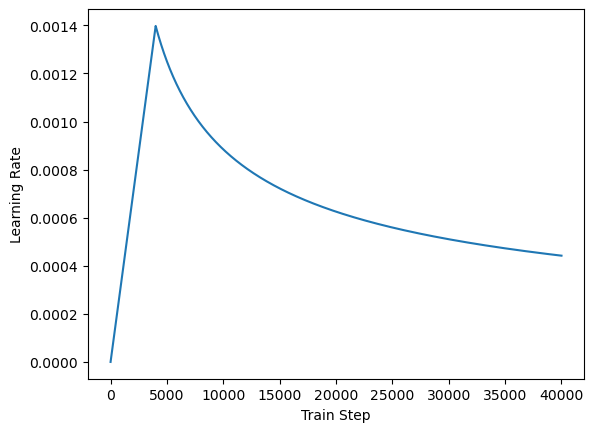

In [43]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

The code you provided defines the following functions and metrics for training a Transformer model:

1. `loss_object`: This is an instance of the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. It is used to compute the loss between the predicted sequences (`pred`) and the target sequences (`real`). The `from_logits=True` argument indicates that the model's output is not normalized with a softmax activation, and the `reduction='none'` argument specifies that no reduction should be applied to the loss values.

2. `loss_function`: This function computes the loss between the predicted sequences (`pred`) and the target sequences (`real`). It applies a mask to ignore padded positions by checking where the `real` values are not equal to 0. The loss is calculated using the `loss_object` and then multiplied by the mask to set the loss values to 0 at padded positions. Finally, the loss values are summed only over non-padded positions and divided by the total number of non-padded positions to get the average loss.

3. `accuracy_function`: This function computes the accuracy of the predicted sequences (`pred`) compared to the target sequences (`real`). It first checks where the predicted sequences match the target sequences (`tf.equal(real, tf.argmax(pred, axis=2))`). Then, a mask is applied to ignore padded positions. The function computes the element-wise logical AND between the mask and the accuracies to only consider non-padded positions. The resulting accuracies are cast to `tf.float32`. Finally, the accuracies are summed only over non-padded positions and divided by the total number of non-padded positions to get the average accuracy.

4. `train_loss`: This is a `tf.keras.metrics.Mean` metric used to track the average training loss during training.

5. `train_accuracy`: This is a `tf.keras.metrics.Mean` metric used to track the average training accuracy during training.

These functions and metrics can be used during the training loop of the Transformer model to compute and track the loss and accuracy metrics.

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [46]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [47]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

The `create_masks` function is used to create masks for the Transformer model during training and inference. It takes two arguments: `inp` (input sequence) and `tar` (target sequence). Here's an explanation of each mask it creates:

1. **Encoder Padding Mask (`enc_padding_mask`):** This mask is used in the encoder to mask the padding tokens in the input sequence. It is created by calling the `create_padding_mask` function on the `inp` sequence.

2. **Combined Mask (`combined_mask`):** This mask is used in the decoder's first attention block. It consists of two sub-masks: the **look-ahead mask** and the **decoder target padding mask**. The look-ahead mask is used to mask the future tokens in the input received by the decoder, preventing it from attending to future positions. The decoder target padding mask is used to mask the padding tokens in the target sequence. The combined mask is created by taking the element-wise maximum of the decoder target padding mask and the look-ahead mask.

3. **Decoder Padding Mask (`dec_padding_mask`):** This mask is used in the decoder to mask the padding tokens in the input sequence. It is created by calling the `create_padding_mask` function on the `inp` sequence.

The `create_masks` function then returns the `enc_padding_mask`, `combined_mask`, and `dec_padding_mask` as output. These masks are used in the training step of the Transformer model to apply appropriate masking during self-attention and feed-forward network computations.

In [48]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

The code snippet provided sets up a checkpointing mechanism for saving and restoring the model during training. Here's a breakdown of the code:

1. `checkpoint_path` is the directory path where the checkpoints will be saved.
2. `ckpt` is a `tf.train.Checkpoint` object that contains the Transformer model (`transformer`) and the optimizer (`optimizer`).
3. `ckpt_manager` is a `tf.train.CheckpointManager` that handles the checkpoint saving and restoring process. It takes the `ckpt` object and the `checkpoint_path` as arguments. The `max_to_keep` parameter specifies the maximum number of checkpoints to keep.
4. The code checks if a latest checkpoint exists using `ckpt_manager.latest_checkpoint`. If a checkpoint exists, it restores the model and optimizer states from the latest checkpoint using `ckpt.restore()`.
5. Finally, it prints a message indicating that the latest checkpoint has been restored.

By using this checkpointing mechanism, you can save the model's parameters and optimizer states during training, allowing you to resume training from the latest checkpoint if training gets interrupted or to load the trained model for inference at a later time.

In [49]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Цель делится на tar_inp и tar_real. tar_inp передается декодеру в качестве входных данных. tar_real - это тот же самый ввод, сдвинутый на 1: в каждом месте tar_input tar_real содержит следующий токен, который должен быть предсказан.

Например, sentence = "SOS Лев в джунглях спит EOS"

tar_inp = "SOS tar_inp лев в джунглях"

tar_real = "Лев в джунглях спит EOS"

Преобразователь - это авторегрессивная модель: он делает прогнозы по частям и использует свои выходные данные, чтобы решить, что делать дальше.

Во время обучения в этом примере используется принуждение учителя (как в учебнике по созданию текста ). Принуждение учителя передает истинный результат следующему временному шагу независимо от того, что модель предсказывает на текущем временном шаге.

Поскольку преобразователь предсказывает каждое слово, самовнимание позволяет ему смотреть на предыдущие слова во входной последовательности, чтобы лучше предсказать следующее слово.

Чтобы модель не просматривала ожидаемый результат, в модели используется маска просмотра вперед.



The `train_step` function is defined as a TensorFlow function with a specific input signature. It takes `inp` and `tar` as input tensors of shape `(None, None)` with dtype `tf.int64`.

Inside the function, the `tar_inp` is obtained by slicing `tar` to exclude the last token, and `tar_real` is obtained by slicing `tar` to exclude the first token.

Next, the masks (`enc_padding_mask`, `combined_mask`, and `dec_padding_mask`) are created using the `create_masks` function.

Within a gradient tape context, the `transformer` model is called with `inp`, `tar_inp`, and the masks to obtain `predictions` (the model's output). The loss is calculated using `loss_function` by comparing `tar_real` with `predictions`.

Gradients are computed with respect to the trainable variables of the `transformer` model using the tape. Then, the optimizer's `apply_gradients` method is used to update the model's trainable variables based on the gradients.

The training loss and accuracy are updated using the `train_loss` and `train_accuracy` metrics, respectively.

In [50]:
EPOCHS = 5

In [51]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Ru is used as the input language and English is the target language.

This code snippet represents the training loop for the Transformer model. Here's what it does:

- It iterates over the specified number of epochs.
- For each epoch, it initializes the training loss and accuracy states.
- It iterates over the batches of the training dataset, where each batch contains input (`inp`) and target (`tar`) sequences.
- For each batch, it calls the `train_step` function to perform a single training step.
- Every 50 batches, it prints the current epoch, batch number, training loss, and training accuracy.
- Every 5 epochs, it saves a checkpoint of the model using the `ckpt_manager.save()` method.
- After each epoch, it prints the epoch loss and accuracy.
- It measures the time taken for each epoch and prints it.
- The loop continues until all epochs are completed.

This training loop allows the Transformer model to be trained on the provided dataset, and the model's performance is monitored through the loss and accuracy metrics. Checkpoints are saved periodically to allow for model checkpointing and resuming training if needed.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0379 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9769 Accuracy 0.0032
Epoch 1 Batch 100 Loss 8.8809 Accuracy 0.0252
Epoch 1 Batch 150 Loss 8.7785 Accuracy 0.0327
Epoch 1 Batch 200 Loss 8.6515 Accuracy 0.0370
Epoch 1 Batch 250 Loss 8.4967 Accuracy 0.0418
Epoch 1 Batch 300 Loss 8.3193 Accuracy 0.0504
Epoch 1 Batch 350 Loss 8.1334 Accuracy 0.0574
Epoch 1 Batch 400 Loss 7.9528 Accuracy 0.0629
Epoch 1 Batch 450 Loss 7.7875 Accuracy 0.0680
Epoch 1 Batch 500 Loss 7.6423 Accuracy 0.0744
Epoch 1 Batch 550 Loss 7.5095 Accuracy 0.0819
Epoch 1 Batch 600 Loss 7.3837 Accuracy 0.0898
Epoch 1 Batch 650 Loss 7.2616 Accuracy 0.0976
Epoch 1 Batch 700 Loss 7.1472 Accuracy 0.1046
Epoch 1 Batch 750 Loss 7.0386 Accuracy 0.1116
Epoch 1 Batch 800 Loss 6.9353 Accuracy 0.1186
Epoch 1 Batch 850 Loss 6.8397 Accuracy 0.1251
Epoch 1 Batch 900 Loss 6.7490 Accuracy 0.1313
Epoch 1 Batch 950 Loss 6.6654 Accuracy 0.1371
Epoch 1 Batch 1000 Loss 6.5853 Accuracy 0.1427
Epoch 1 Batch 1050 Loss 6.5112 Accur

## Evaluate

Для оценки используются следующие шаги:

Закодируйте входное предложение с помощью русского токенизатора ( tokenizer_pt ). Кроме того, добавьте начальный и конечный токены, чтобы ввод был эквивалентен тому, с чем обучается модель. Это вход энкодера.
Вход декодера - это start token == tokenizer_en.vocab_size .
Рассчитайте маски заполнения и маски прогнозирования.
Затем decoder выводит прогнозы, глядя на encoder output и собственные выходные данные (самовнимание).
Выберите последнее слово и вычислите его argmax.
Конкатентируйте предсказанное слово на вход декодера при передаче его в декодер.
В этом подходе декодер предсказывает следующее слово на основе предсказанных им предыдущих слов.


The `evaluate` function takes an input sentence in Portuguese and generates its corresponding translation in English using the trained Transformer model. Here's how it works:

- The input sentence is tokenized using the Portuguese tokenizer (`tokenizer_pt`) and appended with start and end tokens.
- The encoder input is created by expanding the dimensions of the tokenized input sentence.
- The decoder input starts with the English start token (`tokenizer_en.vocab_size`).
- The `output` tensor represents the decoder input sequence, which is expanded with an extra dimension.
- In a loop that runs for a maximum length (`MAX_LENGTH`) or until the end token is predicted:
  - The padding masks (`enc_padding_mask`, `combined_mask`, `dec_padding_mask`) are created using the encoder input and the current decoder output.
  - The Transformer model is called with the encoder input, current decoder output, and the created masks to generate predictions and attention weights.
  - The predicted next token is selected by taking the token with the highest probability (`argmax`) from the predictions.
  - If the predicted token is the end token (`tokenizer_en.vocab_size + 1`), the generated output sequence is returned along with the attention weights.
  - Otherwise, the predicted token is concatenated with the output sequence and the loop continues.
- Finally, the generated output sequence is returned (after removing the extra dimension) along with the attention weights.

This function allows you to provide an input sentence and obtain its translation using the trained Transformer model.

In [53]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

The `plot_attention_weights` function is used to visualize the attention weights for each head of a specific layer in the Transformer model. Here's how it works:

- The function takes the attention tensor, input sentence, generated result, and the layer index as inputs.
- It creates a figure with a size of (16, 8) to accommodate the subplots for each attention head.
- The input sentence is tokenized using the Portuguese tokenizer (`tokenizer_pt`).
- The attention tensor is squeezed to remove the extra dimensions, leaving the attention weights with the shape (num_heads, target_seq_len, input_seq_len+2).
- For each head in the attention tensor, a subplot is added to the figure.
- The attention weights for the current head are visualized using a color map (`cmap='viridis'`).
- The x-axis tick labels represent the tokens in the input sentence (start token, Portuguese tokens, and end token), decoded using the Portuguese tokenizer.
- The y-axis tick labels represent the tokens in the generated result, decoded using the English tokenizer (`tokenizer_en`).
- The x-axis label of each subplot shows the corresponding head index.
- The plot is displayed with tight layout to ensure proper spacing between subplots.

This function allows you to visualize the attention weights for each head of a specific layer, providing insights into the attention mechanism of the Transformer model during translation.

In [54]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

The `translate` function is used to translate a given input sentence from Portuguese to English using the trained Transformer model. Here's how it works:

- The function takes a sentence as input and calls the `evaluate` function to generate the translation result and attention weights.
- The translation result is decoded using the English tokenizer (`tokenizer_en`) to obtain the predicted sentence.
- The input sentence and the predicted translation are printed.
- If the `plot` parameter is provided (not empty), the `plot_attention_weights` function is called to visualize the attention weights. The `plot` parameter specifies the layer for which the attention weights should be plotted.
- The attention weights are used to visualize the alignment between the input sentence and the generated translation at the specified layer.

This function allows you to translate a sentence and optionally visualize the attention weights to gain insights into the translation process of the Transformer model.

In [55]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [56]:
translate('Осенним вечером шёл дождь!')

Input: Осенним вечером шёл дождь!
Predicted translation: the slot was going to go to the rain evening .


In [57]:
translate('он собирается домой')

Input: он собирается домой
Predicted translation: he is going to go home .
